# JungHyun Bang
# 220544997/1




Title : predicting protein solubility 

data set used: eSOL: Solubility data for Ecoli proteins

DOI: [10.18908/lsdba.nbdc00440-001](https://dbarchive.biosciencedbc.jp/en/esol/data-1.html)


In [83]:
import os
import pandas as pd
import requests
import json
import time

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

from sklearn.model_selection import train_test_split


from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import mean_squared_error
import numpy as np

In [ ]:
# define dirs
dataset_dir = r"Q:\coding_dir\Rep_dir\VScode_Lib\testersession\porj\SPC707P\labs\Week12\Protein_Solubility_ML_Model\Dataset"
log_dir = r"Q:\coding_dir\Rep_dir\VScode_Lib\testersession\porj\SPC707P\labs\Week12\Protein_Solubility_ML_Model\logs"

In [34]:

d1 = pd.read_csv(os.path.join(dataset_dir, "esol.csv"))
print(d1.columns)

Index(['JW_ID', 'ECK number', 'B number', 'Gene name K-12', 'Locus name K-12',
       'Synonyms of locus names K-12', 'Solubility (%)', 'Yield (uM)',
       'Yield (ug/ml)', 'Minus Sol (%)', 'TF Sol (%)', 'GroE Sol (%)',
       'KJE Sol (%)', 'Minus Yield (uM)', 'TF Yield (uM)', 'GroE Yield (uM)',
       'KJE Yield (uM)', 'Minus Yield (ug/ml)', 'TF Yield (ug/ml)',
       'GroE Yield (ug/ml)', 'KJE Yield (ug/ml)', 'Calculated MW (kDa)',
       'Calculated pI', 'Type of gene product', 'Gene product description',
       'Cell location', 'Structure (PDB) ID', 'SCOP assignment'],
      dtype='object')


Okay first things first lets try and identify the dimensions that confer with solubility.

Deffo Solubility (%) will be our lable, so this needs to be non-NAN 
"Calculated MW (kDa)", "Calculated pI" these are features that will have direct impact on the solubility i think. We should use this.

biologically speeking, Yeild data('Yield (uM)','Yield (ug/ml)') will have some correlation with solubility but this may result in high correlation issues.

'Type of gene product', 'Cell location' These features may have some critical instance class bias as some classes of proteins may be less expressable(less soluble)  lets keep this for future use.

In [35]:
cols = ["Solubility (%)", "Calculated MW (kDa)", "Calculated pI", "Yield (uM)", "Yield (ug/ml)", "Type of gene product", "Cell location"]
crit_col = ["Solubility (%)", "Calculated MW (kDa)", "Calculated pI"]
print(f"n Tot insatnce: {len(d1)}")

print("n NAN per col ")
print(d1[cols].isna().sum())
print()

print("% of NAN per col")
print(d1[cols].isna().mean())
print()


print("instances with complete data for critical columns")
mask_valid = d1[crit_col].notna().all(axis=1)
print(f"n Logical test ok instances:  {mask_valid.sum()}")
print(f"% Logical test ok instances: {mask_valid.mean()}")


n Tot insatnce: 4132
n NAN per col 
Solubility (%)          959
Calculated MW (kDa)       0
Calculated pI             0
Yield (uM)              959
Yield (ug/ml)           959
Type of gene product      0
Cell location             2
dtype: int64

% of NAN per col
Solubility (%)          0.232091
Calculated MW (kDa)     0.000000
Calculated pI           0.000000
Yield (uM)              0.232091
Yield (ug/ml)           0.232091
Type of gene product    0.000000
Cell location           0.000484
dtype: float64

instances with complete data for critical columns
n Logical test ok instances:  3173
% Logical test ok instances: 0.7679090029041626


Okay i think we can proceed with this.
Now for better model development, we need more features. From UNIPROT, we will be able to get these information....
need some data crawling.

first we will clean the data and append the sequence column.

In [36]:
optional_cols = ["Yield (uM)", "Yield (ug/ml)", "Type of gene product", "Cell location"]
# first we need the lable.. so 
cdf = d1.dropna(subset=["Solubility (%)"]).copy()
print("Clean shape:", cdf.shape)
print(cdf[crit_col].isna().sum())


Clean shape: (3173, 28)
Solubility (%)         0
Calculated MW (kDa)    0
Calculated pI          0
dtype: int64


okay, no need for further cleaning. 

array([[<Axes: title={'center': 'Solubility (%)'}>,
        <Axes: title={'center': 'Calculated MW (kDa)'}>],
       [<Axes: title={'center': 'Calculated pI'}>, <Axes: >]],
      dtype=object)

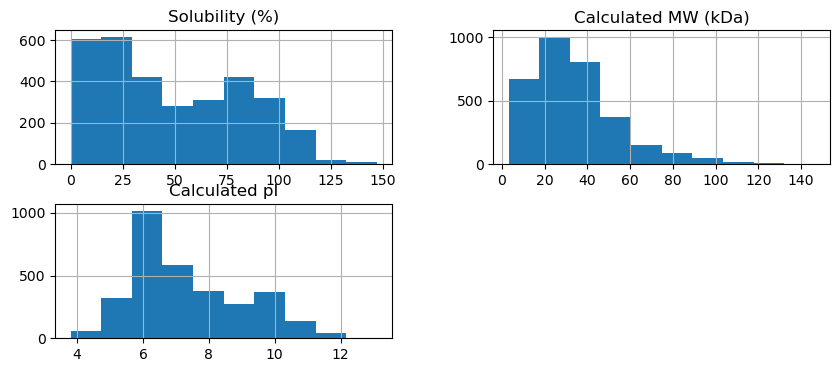

In [37]:
cdf_woptional = cdf[optional_cols].copy()
#storing the additioanl dimensions just incase for further evaluation.

#inspecting the feature distribution.
cdf.describe()
cdf[crit_col].hist(figsize=(10, 4))

Nice, nothing seems unusual. Lets now get the sequence data.

In [38]:
print(cdf.head)

<bound method NDFrame.head of        JW_ID ECK number B number Gene name K-12 Locus name K-12  \
0     JW0002    ECK0003    b0003           thrB            thrB   
1     JW0003    ECK0004    b0004           thrC            thrC   
2     JW0004    ECK0005    b0005           yaaX            yaaX   
3     JW0005    ECK0006    b0006           yaaA            yaaA   
4     JW0007    ECK0008    b0008           talB            talB   
...      ...        ...      ...            ...             ...   
3168  JW4182    ECK4219    b4223           yzfA            yzfA   
3169  JW4184    ECK4221    b4225           chpB            chpB   
3170  JW4195    ECK4231    b4236           cybC            cybC   
3171  JW4196    ECK4232    b4237           nrdG            nrdG   
3172  JW5755    ECK4238    b4243           yjgF            yjgF   

     Synonyms of locus names K-12  Solubility (%)  Yield (uM)  Yield (ug/ml)  \
0                             NaN            32.0         2.3           78.0   
1    

so by searching the Uniprot with the JW_ID, I have discovered this resolves alot of issues(single result).

so we will use the jw_id col as our search varaible.

Its been a while since I used this method.. so lets check the backend json of the search result for JW2231

In [39]:
Targ_ULR = "https://rest.uniprot.org/uniprotkb/search"
params = {
    "query": "JW2231",
    "format": "json",   # full JSON
}

response = requests.get(Targ_ULR, params=params)
print("Status:", response.status_code)

data = response.json()
print(json.dumps(data, indent=4))

save_path = "JW2231_uniprot.json"

# with open(save_path, "w", encoding="utf-8") as f:
#     json.dump(data, f, indent=4)

Status: 200
{
    "results": [
        {
            "entryType": "UniProtKB reviewed (Swiss-Prot)",
            "primaryAccession": "P27294",
            "secondaryAccessions": [
                "P77545"
            ],
            "uniProtkbId": "INAA_ECOLI",
            "entryAudit": {
                "firstPublicDate": "1992-08-01",
                "lastAnnotationUpdateDate": "2025-06-18",
                "lastSequenceUpdateDate": "1997-11-01",
                "entryVersion": 149,
                "sequenceVersion": 3
            },
            "annotationScore": 2.0,
            "organism": {
                "scientificName": "Escherichia coli (strain K12)",
                "taxonId": 83333,
                "lineage": [
                    "Bacteria",
                    "Pseudomonadati",
                    "Pseudomonadota",
                    "Gammaproteobacteria",
                    "Enterobacterales",
                    "Enterobacteriaceae",
                    "Escherichia"


            "sequence": {
                "value": "MAVSAKYDEFNHWWATEGDWVEEPNYRRNGMSGVQCVERNGKKLYVKRMTHHLFHSVRYPFGRPTIVREVAVIKELERAGVIVPKIVFGEAVKIEGEWRALLVTEDMAGFISIADWYAQHAVSPYSDEVRQAMLKAVALAFKKMHSINRQHGCCYVRHIYVKTEGNAEAGFLDLEKSRRRLRRDKAINHDFRQLEKYLEPIPKADWEQVKAYYYAM",
                "length": 216,
                "molWeight": 25296,
                "crc64": "49B8E72F553113FD",
                "md5": "B5EC566BFBE36672B78744D86C0B9E27"
            },
This is the part that we are interested in.

Now lets just extract this bit..

In [40]:
def fetch_uniprot_seq_by_jw(jw_id):
    if pd.isna(jw_id):
        return None, "JW_ID is NaN"

    query = f"{jw_id} AND organism_id:83333"
    
    params = {
        "query": query,
        "fields": "accession,id,gene_names,organism_id,sequence",
        "format": "tsv",
        "size": 5
    }

    try:
        r = requests.get(Targ_URL, params=params)

        if r.status_code != 200:
            return None, f"HTTP {r.status_code}: {r.text[:200]}"

        text = r.text.strip()
        if not text:
            return None, "Empty response"

        lines = text.splitlines()
        if len(lines) <= 1:
            return None, "No hits"

        header = lines[0].split("\t")
        if "Sequence" not in header:
            return None, f"'Sequence' column missing. Header={header}"

        seq_idx = header.index("Sequence")
        first = lines[1].split("\t")
        seq = first[seq_idx]

        if seq == "":
            return None, "Empty sequence"

        return seq, None

    except Exception as e:
        return None, f"Exception: {str(e)}"


In [41]:
def add_sequences_with_progress(cdf, id_col="JW_ID", sleep_sec=0.2):
    df = cdf.copy()
    df["UniProt_seq"] = None

    unique_ids = df[id_col].dropna().unique()
    total = len(unique_ids)

    id_to_seq = {}
    error_log = []

    for i, jw in enumerate(unique_ids, start=1):

        seq, err = fetch_uniprot_seq_by_jw(jw)
        id_to_seq[jw] = seq        
        if err is None:
            print(f"[{i}/{total}] {jw}: OK")                # keeping  track of the progression
        else:
            print(f"[{i}/{total}] {jw}: FAIL → {err}")
            error_log.append({"JW_ID": jw, "Error": err})

        time.sleep(sleep_sec)

    df["UniProt_seq"] = df[id_col].map(id_to_seq)
    err_df = pd.DataFrame(error_log)
    return df, id_to_seq, err_df

In [43]:
cdf_seq, seq_map, err_df = add_sequences_with_progress(cdf)
cdf_seq.to_csv(os.path.join(dataset_dir, "esol_with_sequences.csv"), index=False)
err_df.to_csv(os.path.join(log_dir, "uniprot_sequence_errors.csv"), index=False)

print("DONE!")


[1/3173] JW0002: OK
[2/3173] JW0003: OK
[3/3173] JW0004: OK
[4/3173] JW0005: OK
[5/3173] JW0007: OK
[6/3173] JW0008: OK
[7/3173] JW5001: OK
[8/3173] JW0012: OK
[9/3173] JW0013: OK
[10/3173] JW0014: OK
[11/3173] JW5002: OK
[12/3173] JW0019: OK
[13/3173] JW0022: OK
[14/3173] JW0023: OK


KeyboardInterrupt: 

In [47]:
cdf_final = cdf_seq.dropna(subset=["UniProt_seq"]).copy()
print("Final dataset shape:", cdf_final.shape)
cdf_final.to_csv(os.path.join(dataset_dir,"cdf_final.csv"), index=False)

Final dataset shape: (3150, 29)


Out of the 3173 entries with valid solubility measurements, 23 proteins could not be mapped to UniProtKB using their JW_ID identifiers. These entries were excluded from sequence-based modelling due to missing primary structure information. The missing cases were logged separately and likely correspond to deprecated or unannotated ORFs in the E. coli K-12 reference strain.

The final dataset contained 3150 instances and 29 dimensions


# Feature engineering

##### Basic features (Level 2)
- Length
- 20 AA fractional composition (20개)
- Residue group fractions
- frac_pos = (K+R+H)/L
- frac_neg = (D+E)/L
- frac_charged = (K+R+H+D+E)/L
- frac_polar = (S+T+N+Q+Y+C)/L
- frac_hydrophobic = (A+V+L+I+M+F+W+Y)/L
- frac_aromatic = (F+W+Y)/L
- frac_turn = (N+G+P+S)/L

##### Extended features (Level 2)
- GRAVY
- Aliphatic index
- Aromaticity index
- Instability index
- Net charge at pH 7


In [ ]:
import math
import pandas as pd

AA20 = list("ACDEFGHIKLMNPQRSTVWY")

# Kyte–Doolittle hydropathy index (for GRAVY)
KD = {"A": 1.8, "C": 2.5, "D": -3.5, "E": -3.5, "F": 2.8,
    "G": -0.4, "H": -3.2, "I": 4.5, "K": -3.9, "L": 3.8,
    "M": 1.9, "N": -3.5, "P": -1.6, "Q": -3.5, "R": -4.5,
    "S": -0.8, "T": -0.7, "V": 4.2, "W": -0.9, "Y": -1.3}

# pKa values for net charge at pH 7 (very standard approximations)
PKA_N_TERM = 9.6
PKA_C_TERM = 2.4
PKA_SIDE = {"D": 4.0,"E": 4.4,"H": 6.5,"C": 8.5,
            "Y": 10.0,"K": 10.5,"R": 12.5,}

def henderson_hasselbalch_acid(pH, pKa):        #deprotonation for DECY
    return 1.0 / (1.0 + 10 ** (pKa - pH))

def henderson_hasselbalch_base(pH, pKa):        #deprotonation for KRH
    return 1.0 / (1.0 + 10 ** (pH - pKa))

def seq_to_features(seq, pH=7.0):           # feat dict 
    if not isinstance(seq, str):            # error guard
        return None, "Sequence is not a string"

    seq = seq.strip().upper()
    clean = [aa for aa in seq if aa in AA20]
    qlen = len(clean)

    if qlen == 0:
        return None, "Sequence contains no valid amino acids (length=0)"

    try:
        counts = {aa: 0 for aa in AA20}     # initialisiong count dict
        for aa in clean:
            counts[aa] += 1

        fracs = {aa: counts[aa] / qlen for aa in AA20}      # fracctionating or getting %
        pos_set = set("KRH")                                # converting to single str per physical chars.
        neg_set = set("DE")
        charged_set = set("KRHDE")
        polar_set = set("STNQYC")
        hydrophobic_set = set("AVLIMFWY")
        aromatic_set = set("FWY")
        turn_set = set("NGPS")

        frac_pos = sum(fracs[a] for a in pos_set)           
        frac_neg = sum(fracs[a] for a in neg_set)
        frac_charged = sum(fracs[a] for a in charged_set)
        frac_polar = sum(fracs[a] for a in polar_set)
        frac_hydrophobic = sum(fracs[a] for a in hydrophobic_set)
        frac_aromatic = sum(fracs[a] for a in aromatic_set)
        frac_turn = sum(fracs[a] for a in turn_set)

        # gravy
        gravy = sum(KD[a] for a in clean) / qlen

        # aliphatic index
        xA = fracs["A"]
        xV = fracs["V"]
        xI = fracs["I"]
        xL = fracs["L"]

        aliphatic_index = 100.0 * (xA + 2.9*xV + 3.9*(xI + xL))     #PMID: 7462208

        # aromaticity index
        aromaticity_index = frac_aromatic

        # placeholder instability index : i noticed the calculations are quite complex for this we will come back to this later.
        instability_index = None            # PMID 2075190

        # net charge
        n_term_charge = henderson_hasselbalch_base(pH, PKA_N_TERM)
        c_term_charge = -henderson_hasselbalch_acid(pH, PKA_C_TERM)

        side_charge = 0.0
        for aa in clean:
            if aa in ("D","E","C","Y"):
                side_charge += -henderson_hasselbalch_acid(pH, PKA_SIDE[aa])
            elif aa in ("K","R","H"):
                side_charge += henderson_hasselbalch_base(pH, PKA_SIDE[aa])

        net_charge = n_term_charge + c_term_charge + side_charge

        # collect
        feats = {
            "length": L,
            "gravy": gravy,
            "aliphatic_index": aliphatic_index,
            "aromaticity_index": aromaticity_index,
            "instability_index": instability_index,
            "net_charge_pH7": net_charge,
            "frac_pos": frac_pos,
            "frac_neg": frac_neg,
            "frac_charged": frac_charged,
            "frac_polar": frac_polar,
            "frac_hydrophobic": frac_hydrophobic,
            "frac_aromatic": frac_aromatic,
            "frac_turn": frac_turn
        }

        for aa in AA20:
            feats[f"aa_{aa}"] = fracs[aa]

        return feats, None

    except Exception as e:
        return None, f"Exception during feature extraction: {str(e)}"

In [ ]:
def combdimensionmatrix(df, seq_col="UniProt_seq",
                         extra_cols=("Calculated MW (kDa)", "Calculated pI")):

    feat_rows = []
    idx_list = []
    error_log = []

    for idx, seq in df[seq_col].items():
        feats, err = seq_to_features(seq)

        if err is not None:
            error_log.append({"Index": idx, "Error": err})
            continue

        feat_rows.append(feats)
        idx_list.append(idx)

    X = pd.DataFrame(feat_rows, index=idx_list)

    if extra_cols is not None:
        extra = df.loc[idx_list, list(extra_cols)].copy()
        X = pd.concat([X, extra], axis=1)

    error_df = pd.DataFrame(error_log)

    return X, error_df

<bound method NDFrame.head of Empty DataFrame
Columns: []
Index: []>
(3150, 35)


# Planning the model

- Although solubility is naturally a continuous property, some applications (e.g., recombinant protein expression screening) only require a binary soluble/insoluble decision.
Therefore, after training a regression model, we additionally examined various classification thresholds. The optimal threshold was found to be X based on maximizing F1-score.<<<<<- ? >


so, the main model will be a regression(Ridge) with target = solubility %

Metrics: 
- RMSE 
- MAE
- $R^2$

Cross validation
KFold + confusion matrix 

Learning curve
Hyperparameter tuning: Finding ridge a val.


further classification with the results(?)

In [80]:
X_features_clean = X_features.dropna(axis=1, how="all")
# we left the instability column blank...
# we need to drop this.


# setting target.
y_reg = cdf_final.loc[X_features_clean.index, "Solubility (%)"]

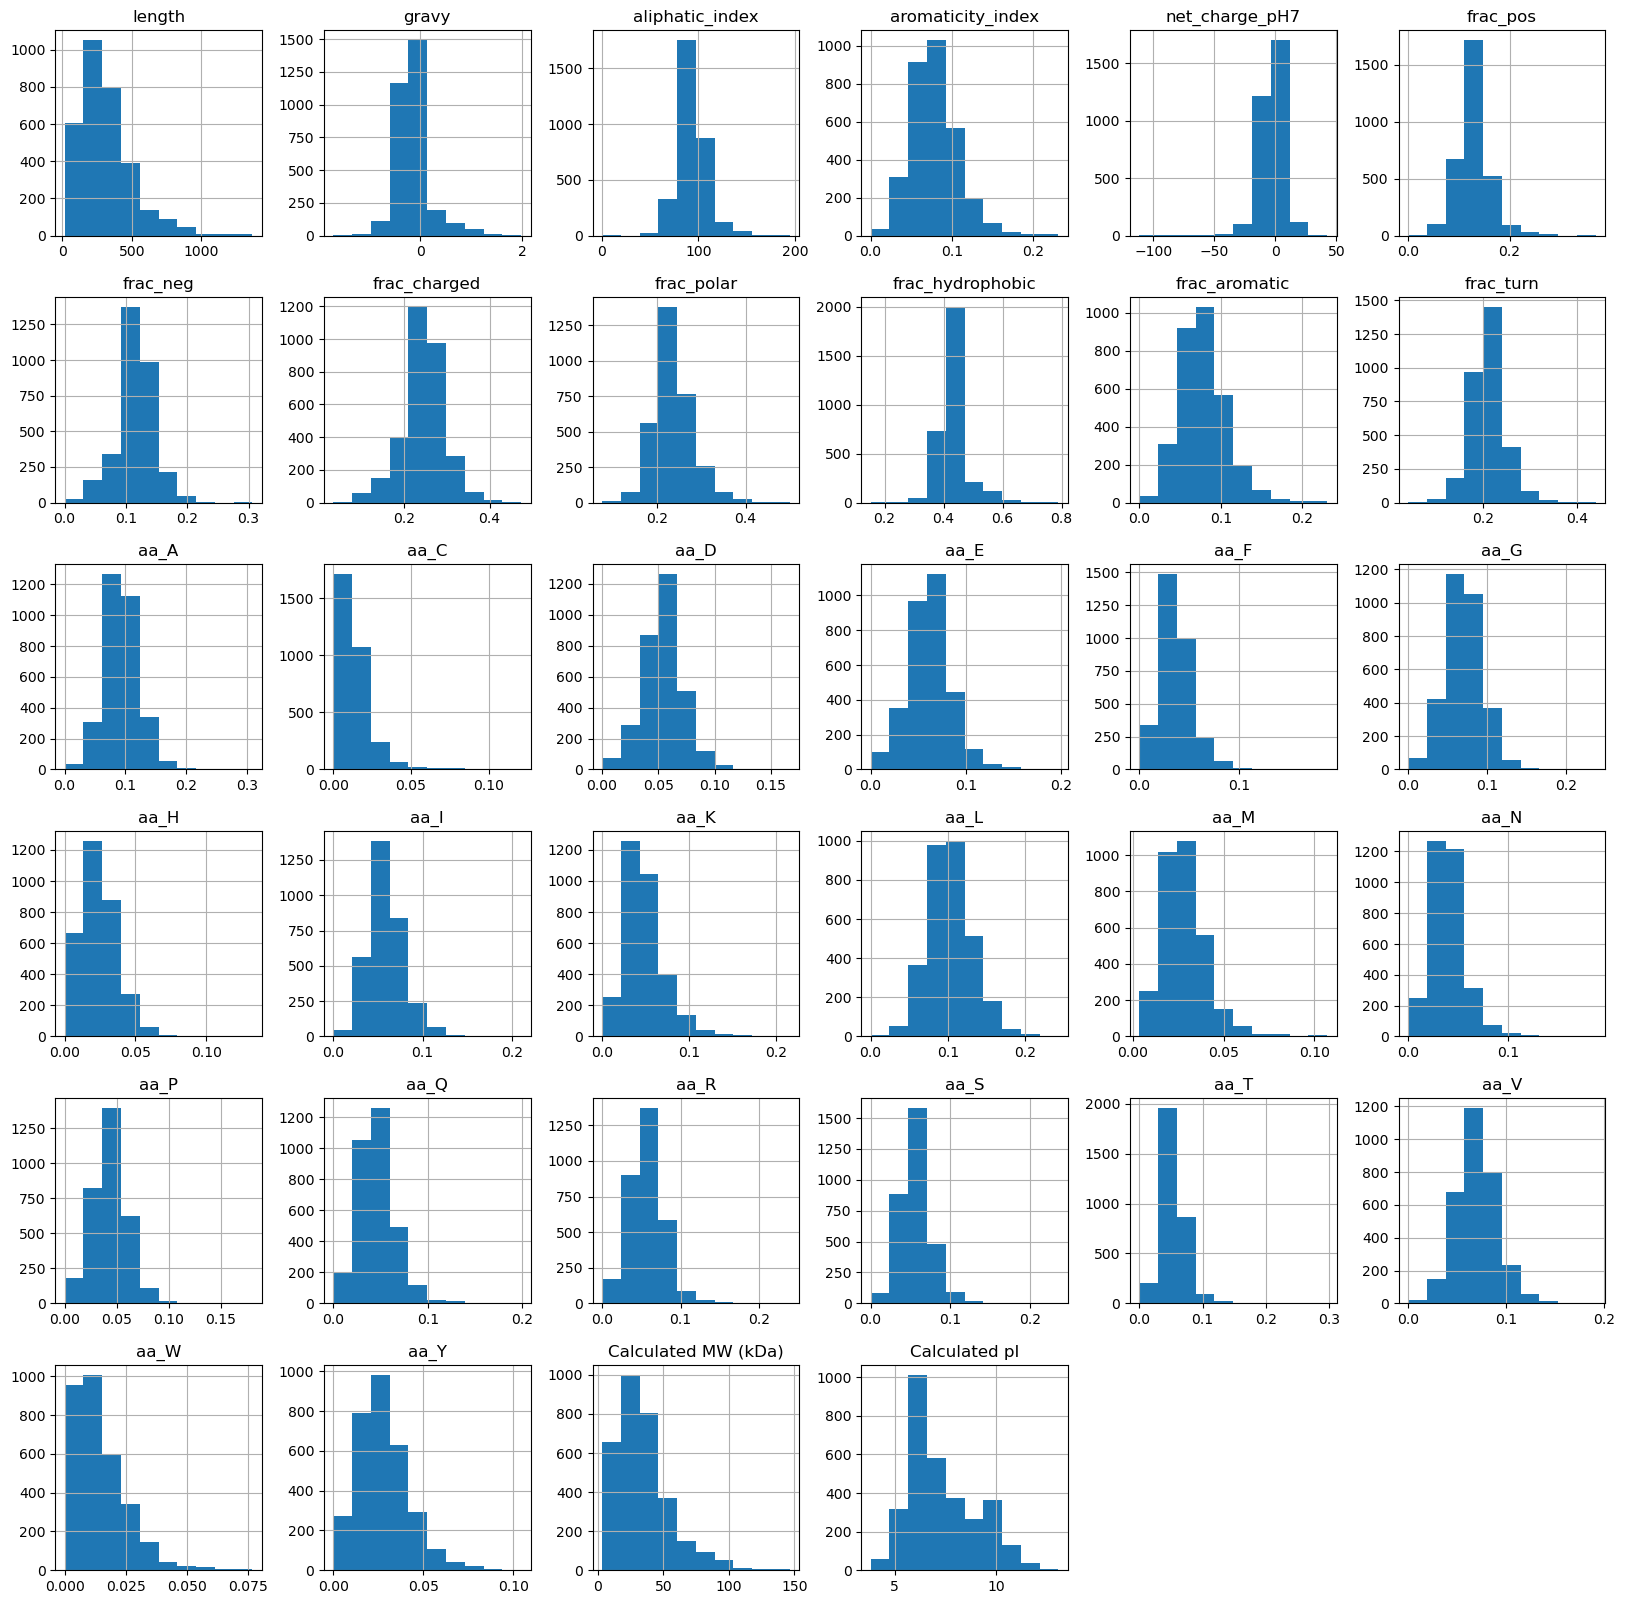

In [90]:
import matplotlib.pyplot as plt
X_features_clean.describe()
X_features_clean.hist(figsize=(20, 20))
plt.savefig("feature_histograms.png", dpi=300)

In [86]:
X_tr, X_te, y_tr, y_te = train_test_split(
    X_features_clean, y_reg,
    test_size=0.2,
    random_state=42
)

print("Train:", X_tr.shape, y_tr.shape)
print("Test :", X_te.shape, y_te.shape)

Train: (2520, 34) (2520,)
Test : (630, 34) (630,)


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

rg_pipe = Pipeline([
    ("sc", StandardScaler()),
    ("rg", Ridge(alpha=1.0))    # setting alpha to 1 for now reffering to the previous worksheet...
])

rg_pipe.fit(X_tr, y_tr)

y_tr_pred = rg_pipe.predict(X_tr)
y_te_pred = rg_pipe.predict(X_te)

tr_mse = mean_squared_error(y_tr, y_tr_pred)
te_mse = mean_squared_error(y_te, y_te_pred)

tr_rmse = np.sqrt(tr_mse)
te_rmse = np.sqrt(te_mse)

tr_mae = mean_absolute_error(y_tr, y_tr_pred)
te_mae = mean_absolute_error(y_te, y_te_pred)

tr_r2 = r2_score(y_tr, y_tr_pred)
te_r2 = r2_score(y_te, y_te_pred)

print("Ridge (alpha=1.0)")
print(f"  train RMSE: {tr_rmse:.3f}, MAE: {tr_mae:.3f}, R²: {tr_r2:.3f}")
print(f"  test  RMSE: {te_rmse:.3f}, MAE: {te_mae:.3f}, R²: {te_r2:.3f}")


Ridge (alpha=1.0)
  train RMSE: 26.079, MAE: 21.420, R²: 0.387
  test  RMSE: 26.090, MAE: 21.059, R²: 0.398


In [76]:
from sklearn.model_selection import KFold, cross_validate

cv = KFold(n_splits=5, shuffle=True, random_state=42)

sc = cross_validate(
    rg_pipe,
    X_features_clean,
    y_reg,
    cv=cv,
    scoring={
        "r2": "r2",
        "rmse": "neg_root_mean_squared_error",
        "mae": "neg_mean_absolute_error",
    },
    return_train_score=True
)

print("CV train R² :", sc["train_r2"].mean(), "±", sc["train_r2"].std())
print("CV test  R² :", sc["test_r2"].mean(), "±", sc["test_r2"].std())

print("CV test  RMSE:", -sc["test_rmse"].mean())
print("CV test  MAE :", -sc["test_mae"].mean())


CV train R² : 0.39156312618520994 ± 0.0057458641340572955
CV test  R² : 0.37819892290213875 ± 0.025193972345035415
CV test  RMSE: 26.273160925333077
CV test  MAE : 21.482300274000046


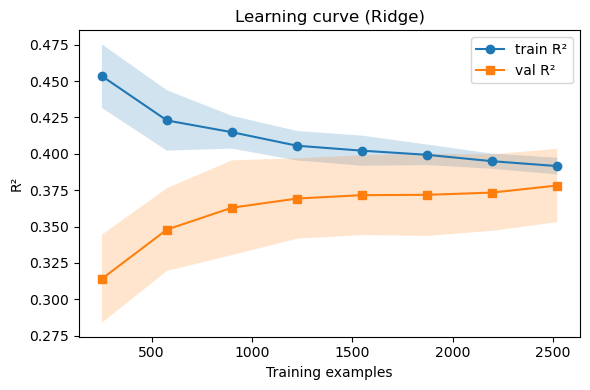

In [77]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

train_sizes, train_scores, val_scores = learning_curve(
    rg_pipe,
    X_features_clean,
    y_reg,
    cv=cv,
    scoring="r2",
    train_sizes=np.linspace(0.1, 1.0, 8),
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_std = val_scores.std(axis=1)

plt.figure(figsize=(6,4))
plt.plot(train_sizes, train_mean, marker="o", label="train R²")
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.2)

plt.plot(train_sizes, val_mean, marker="s", label="val R²")
plt.fill_between(train_sizes, val_mean-val_std, val_mean+val_std, alpha=0.2)

plt.xlabel("Training examples")
plt.ylabel("R²")
plt.title("Learning curve (Ridge)")
plt.legend()
plt.tight_layout()
plt.show()


In [84]:
alphas = np.logspace(-4, 4, 9)  # 너무 극단적이지 않게 범위 줄임
MSE = []

cv = KFold(n_splits=5, shuffle=True, random_state=42)

for a in alphas:
    model_reg = make_pipeline(
        StandardScaler(),
        Ridge(alpha=a, max_iter=10000)
    )

    scores = cross_validate(
        model_reg,
        X_features_clean,
        y_reg,
        cv=cv,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )

    mean_mse = -np.mean(scores['test_score'])
    MSE.append(mean_mse)

    print(f"alpha={a:.4e}, CV MSE={mean_mse:.3f}")

best_alpha = alphas[np.argmin(MSE)]
print("\nBest alpha from CV:", best_alpha)


alpha=1.0000e-04, CV MSE=690.742
alpha=1.0000e-03, CV MSE=690.742
alpha=1.0000e-02, CV MSE=690.742
alpha=1.0000e-01, CV MSE=690.739
alpha=1.0000e+00, CV MSE=690.710
alpha=1.0000e+01, CV MSE=690.496
alpha=1.0000e+02, CV MSE=690.392
alpha=1.0000e+03, CV MSE=706.319
alpha=1.0000e+04, CV MSE=851.532

Best alpha from CV: 100.0


In [ ]:
# 1) Train/Test split
X_tr, X_te, y_tr, y_te = train_test_split(
    X_features_clean,
    y_reg,
    test_size=0.2,
    random_state=42
)

best_pipe = Pipeline([
    ("sc", StandardScaler()),
    ("rg", Ridge(alpha=best_alpha, max_iter=10000))
])

best_pipe.fit(X_tr, y_tr)

y_tr_pred = best_pipe.predict(X_tr)
y_te_pred = best_pipe.predict(X_te)

tr_mse = mean_squared_error(y_tr, y_tr_pred)
te_mse = mean_squared_error(y_te, y_te_pred)

tr_rmse = np.sqrt(tr_mse)
te_rmse = np.sqrt(te_mse)

from sklearn.metrics import mean_absolute_error, r2_score

tr_mae = mean_absolute_error(y_tr, y_tr_pred)
te_mae = mean_absolute_error(y_te, y_te_pred)

tr_r2 = r2_score(y_tr, y_tr_pred)
te_r2 = r2_score(y_te, y_te_pred)

print(f"\nFinal model (alpha={best_alpha:.4e})")
print(f"  Train RMSE={tr_rmse:.3f}, MAE={tr_mae:.3f}, R²={tr_r2:.3f}")
print(f"  Test  RMSE={te_rmse:.3f}, MAE={te_mae:.3f}, R²={te_r2:.3f}")


Final model (alpha=1.0000e+02)
  Train RMSE=26.105, MAE=21.469, R²=0.386
  Test  RMSE=26.044, MAE=21.150, R²=0.400
